In [ ]:
!pip install -U -q PyDrive

In [ ]:
import sqlite3
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
!mkdir data

In [ ]:
file_id = '1KiOvhsdjJqaUCLJa5adZXEtQ_72s8Eb6'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data/checking-logs.sqlite')

In [ ]:
conn = sqlite3.connect('data/checking-logs.sqlite')

In [ ]:
commits = pd.io.sql.read_sql(
    "select timestamp from checker where uid like 'user_%'",
    conn, parse_dates=['timestamp']
    )

In [ ]:
conn.close()

In [ ]:
commits['date'] = commits['timestamp'].dt.floor('d')
commits['hour'] = commits['timestamp'].dt.hour
commits = commits.drop('timestamp', axis=1)

In [ ]:
commits.head()

,date,hour
0,2020-04-17,5
1,2020-04-17,5
2,2020-04-17,5
3,2020-04-17,5
4,2020-04-17,5


In [ ]:
working_day = commits.loc[commits['date'].dt.dayofweek < 5]
weekend = commits.loc[commits['date'].dt.dayofweek >= 5]

In [ ]:
working_day.head()

,date,hour
0,2020-04-17,5
1,2020-04-17,5
2,2020-04-17,5
3,2020-04-17,5
4,2020-04-17,5


In [ ]:
weekend.head()

,date,hour
23,2020-04-18,7
24,2020-04-18,13
25,2020-04-18,13
26,2020-04-18,13
27,2020-04-18,13


In [ ]:
df_1 = working_day.groupby('hour').date.value_counts().unstack(0)

In [ ]:
df_1.head()

hour,0,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2020-04-17,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,8.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,3.0,7.0,NaN,3.0,NaN,10.0,NaN,NaN,NaN,NaN
2020-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,6.0,2.0,6.0,NaN,2.0,NaN
2020-04-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,NaN,4.0,10.0,1.0,3.0,6.0,NaN
2020-04-23,2.0,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,4.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,2.0,18.0,NaN,NaN


In [ ]:
df_2 = weekend.groupby('hour').date.value_counts().unstack(0)

In [ ]:
df_2.head()

hour,0,1,3,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2020-04-18,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,5.0,3.0,25.0,NaN,7.0,8.0,6.0,4.0,5.0,5.0,NaN
2020-04-19,2.0,NaN,NaN,2.0,NaN,NaN,2.0,7.0,5.0,NaN,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,8.0,NaN,NaN
2020-04-25,NaN,NaN,1.0,NaN,10.0,8.0,3.0,NaN,8.0,7.0,NaN,4.0,8.0,6.0,15.0,8.0,4.0,10.0,8.0,3.0,1.0
2020-04-26,2.0,NaN,NaN,NaN,2.0,6.0,NaN,10.0,8.0,14.0,6.0,7.0,14.0,27.0,16.0,27.0,47.0,50.0,18.0,5.0,2.0
2020-05-02,NaN,NaN,NaN,NaN,3.0,1.0,2.0,1.0,84.0,19.0,26.0,28.0,18.0,24.0,2.0,NaN,10.0,8.0,NaN,NaN,16.0


In [ ]:
index = pd.RangeIndex(stop=24)

In [ ]:
df_1 = df_1.mean()
df_1 = df_1.reindex(index=index, fill_value=0)
df_1 = df_1.rename('working_day')

In [ ]:
df_1.head()

0    3.0
1    0.0
2    0.0
3    2.0
4    0.0
Name: working_day, dtype: float64

In [ ]:
df_2 = df_2.mean()
df_2 = df_2.reindex(index=index, fill_value=0)
df_2 = df_2.rename('weekend')

In [ ]:
df_2.head()

0    2.0
1    6.0
2    0.0
3    1.0
4    0.0
Name: weekend, dtype: float64

In [ ]:
df_1[17]

16.0

In [ ]:
df_2[17]

7.142857142857143

In [ ]:
df = pd.concat([df_1, df_2], axis=1)
df = df.rename_axis('hour')

In [ ]:
df.head()

,working_day,weekend
hour,,
0,3.0,2.0
1,0.0,6.0
2,0.0,0.0
3,2.0,1.0
4,0.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   working_day  24 non-null     float64
 1   weekend      24 non-null     float64
dtypes: float64(2)
memory usage: 512.0 bytes


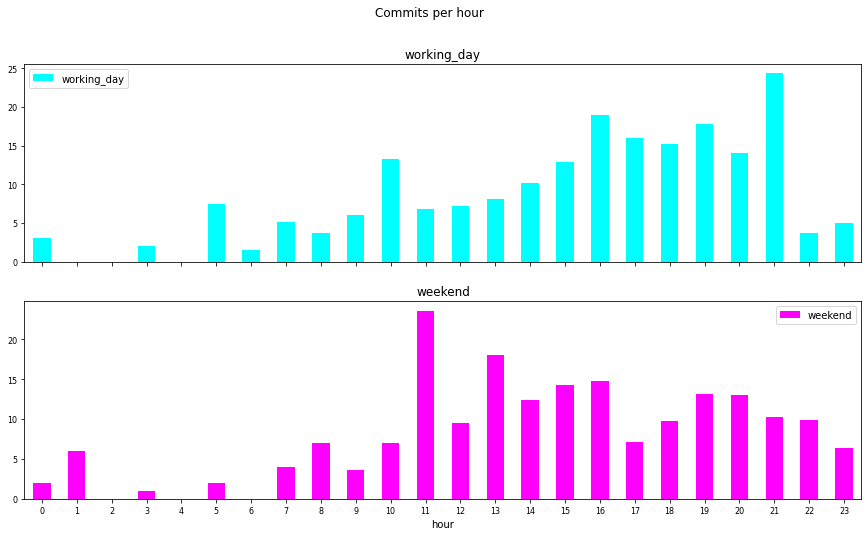

In [ ]:
ax = df.plot.bar(figsize=(15, 8), title='Commits per hour', rot=0, fontsize=8,
                 colormap='cool', sharex=True, subplots=True)

In [ ]:
df['working_day'].idxmax()

21

Час, когда происходит наибольшее число коммитов в будние дни – 21.

In [ ]:
df['weekend'].idxmax()

11

Час, когда происходит наибольшее число коммитов в выходные – 11.